In [4]:
# Starting from plain text files stored on disk
# Binary classifier first to perform sentiment analysis on an IMDB dataset

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
print(tf.__version__)

2.4.0


In [7]:
# This notebook train a sent, iment analysis model to classify movie reviews as positive or negative,
# based on the text of the review.

In [9]:
# Download and explore the IMDB dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 11s 0us/step


In [10]:
os.path.dirname(dataset)

'.'

In [11]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'README', 'imdb.vocab', 'train']

In [12]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'unsupBow.feat',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'urls_neg.txt',
 'pos',
 'urls_unsup.txt']

In [13]:
# aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review.
# Take a look one file
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')

with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [14]:
# Load data off disk and prepare it into a format suitable for training
# Use tf.keras.preprocessing.text_dataset_from_directory()
# main_directory
# ....... class_a  -> with label 0
# ............
#.........class_b  -> with label 1

In [15]:
# To use tf.keras.preprocessing.text_dataset_from_directory()
# delete other directory except pos and neg -> that is unsup directory
remove_dir = os.path.join(train_dir, 'unsup')

# recursively delete an entire directory tree
shutil.rmtree(remove_dir)

In [17]:
os.listdir(train_dir)

['unsupBow.feat',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'urls_neg.txt',
 'pos',
 'urls_unsup.txt']

In [25]:
# when learning a machine learning experiment, it is a best practice to divide
# your dataset into three split : train, validation and test

# Now we don't have val set so, we divide a trainingset

batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train'
    , batch_size = batch_size
    , validation_split = 0.2
    , subset = 'training' 
    , seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [28]:
# I am new to tf.data, explore it.

for text_batch, label_batch in raw_train_ds.take(1):

  print(len(text_batch.numpy())) # 32 : batch_size
  for i in range(3):
    print('review', text_batch[i])
    print('Label', label_batch[i])

32
review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br 

In [33]:
# create validation set
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [34]:
# create test set
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


In [40]:
# Prepare the dataset for training
# Standardization, Tokenization, vectorization

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

  # re.escape(pattern) : escape special characters in pattern. 

  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [41]:
# create TextVectorization

max_features = 10000
sequence_length = 250

# split ; default - 'whitespace
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [42]:
# call adapt to fit the state of the preprocessing layer to the dataset
# Note: it is important to only use training data when calling adapt

# make a text-only dataset (without labels) , then call adapt
train_text = raw_train_ds.map(lambda x, y : x)
vectorize_layer.adapt(train_text)

In [43]:
# function to see the result of using this layer to preprocess some data
def vectorize_text(text, label):

  # why do we need this line?
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [46]:
# retreive a batch from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[0]
print('review', first_review)
print('Label', raw_train_ds.class_names[first_label])
print('Vectorized review', vectorize_text(first_review, first_label))

review tf.Tensor(b"I went to see Fever Pitch with my Mom, and I can say that we both loved it. It wasn't the typical romantic comedy where someone is pining for the other, and blah blah blah... You weren't waiting for the climatic first kiss or for them to finally get together. It was more real, because you saw them through the relationship, rather than the whole movie be about them getting together. People could actually relate to the film, because it didn't seem like extraordinary circumstances, or impossible situations. It was really funny, and I think it was Jimmy Fallon's best performance. All in all... I would definitely recommend it!", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  426,    6,   67, 3775, 3322,   16,   54, 1611,    3,   10,
          68,  131,   12,   71,  192,  446,    9,    9,  269,    2,  769,
         736,  220,  114,  282,    7,    1,   15,    2,   78,    3, 2642,
        2642, 2642,   22, 

In [48]:
# look up the token
print('1287 --> ', vectorize_layer.get_vocabulary()[1287])
print('vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 -->  silent
vocabulary size: 10000


In [49]:
# Finally, apply the TextVectorization layer to train, validation, test
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [50]:
# cache()
# tf.data.Dataset.cache : this will save some operations (like file opening and data reading)
# prefetch()
# overlaps the preprocessing and model execution of a training step. 
# While the model is executing training step s, the input pipeline is reading the data for step s+1

# Tune parameter automatically
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [51]:
# Create the model
embedding_dim = 16

In [52]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Loss function and optimizer
# Since this is a binary classification : losses.BinaryCrossentropy

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)) # why 0.0? because we have only 0 & 1?

In [55]:
# Train the model
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 9s 14ms/step - loss: 0.6820 - binary_accuracy: 0.6166 - val_loss: 0.6134 - val_binary_accuracy: 0.7768
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5786 - binary_accuracy: 0.7867 - val_loss: 0.4969 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 3s 6ms/step - loss: 0.4646 - binary_accuracy: 0.8357 - val_loss: 0.4188 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3895 - binary_accuracy: 0.8623 - val_loss: 0.3728 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 3s 6ms/step - loss: 0.3424 - binary_accuracy: 0.8765 - val_loss: 0.3444 - val_binary_accuracy: 0.8696
Epoch 6/10
625/625 [==============================] - 3s 6ms/step - loss: 0.3112 - binary_accuracy: 0.8880 - val_loss: 0.3255 - val_binary_accuracy: 0.8724
Epoch 7/10
625/625 [==============================] - 4s 6ms/st

In [56]:
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3097 - binary_accuracy: 0.8740
Loss:  0.3097499907016754
Accuracy:  0.873960018157959


In [57]:
# Create a plot of accuracy and loss over time
# model.fit() returns a history object that contains a dictionary with everything that happened during training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

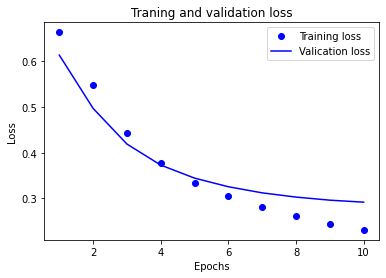

In [58]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) +1) # x-axis

# 'bo' is for 'blue dot'
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Valication loss')
plt.title('Traning and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

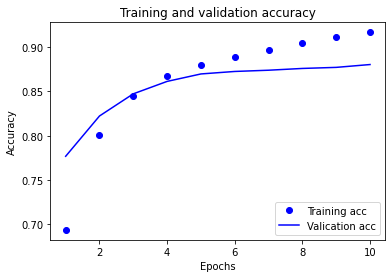

In [60]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Valication acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [61]:
# The validation loss and accuracy seem to peak before the training accuracy
# This is an example of overfitting

In [62]:
# If we want to make our model capable of processing raw strings, 
# we can include TextVectorization layer inside our model

In [63]:
export_model = tf.keras.Sequential([
          vectorize_layer,
          model,
          layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Test it with 'raw_test_ds', which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 10ms/step - loss: 0.3048 - accuracy: 0.8755
0.873960018157959


In [64]:
# Inference on new data

examples = [
      'The movie was greate!',
      'The movie was okay',
      'The movie was terrible...'
]

export_model.predict(examples)

array([[0.52687746],
       [0.4720568 ],
       [0.38577566]], dtype=float32)